In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from Utils import SegGen
import numpy as np
import shutil
import time

Direcciones de imagenes de entrenamiento

In [2]:
# Dirección de carpetas para entrenamiento
train_path_rx =  'Data/Segmentacion/train/inputs' 
train_path_mask = 'Data/Segmentacion/train/targets'

# Dirección de carpetas para validación
validation_path_rx =  'Data/Segmentacion/validation/inputs' 
validation_path_mask = 'Data/Segmentacion/validation/targets'

# Dirección de carpetas para entrenamiento
test_path_rx =  'Data/Segmentacion/test/inputs' 
test_path_mask = 'Data/Segmentacion/test/targets'

# Lista de imagenes dentro de las carpetas
train_ids = np.array(os.listdir(train_path_rx))
validation_ids = np.array(os.listdir(validation_path_rx))
test_ids = np.array(os.listdir(test_path_rx))

path_save_modelos = "Models/Sementacion/Validacion"


Creación del modelo unet

In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c
     

def UNet(image_size,f = [16, 32, 64, 128, 256], activation = 'sigmoid'):

    inputs = keras.layers.Input((image_size, image_size, 1))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation= activation)(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [4]:
# Listas para comparar la precisión y perdida de los modelos
Acuracy = []
Loss = []
model_name_all = []

Epoch 1/6
3619/3619 [==============================] - 929s 251ms/step - loss: 0.1149 - acc: 0.9534 - val_loss: 0.0533 - val_acc: 0.9794
Epoch 2/6
3619/3619 [==============================] - 314s 87ms/step - loss: 0.0522 - acc: 0.9800 - val_loss: 0.0442 - val_acc: 0.9823
Epoch 3/6
3619/3619 [==============================] - 305s 84ms/step - loss: 0.0463 - acc: 0.9823 - val_loss: 0.0393 - val_acc: 0.9844
Epoch 4/6
3619/3619 [==============================] - 304s 84ms/step - loss: 0.0443 - acc: 0.9833 - val_loss: 0.0380 - val_acc: 0.9850
Epoch 5/6
3619/3619 [==============================] - 303s 84ms/step - loss: 0.0395 - acc: 0.9845 - val_loss: 0.0558 - val_acc: 0.9804
Epoch 6/6
3619/3619 [==============================] - 303s 84ms/step - loss: 0.0355 - acc: 0.9858 - val_loss: 0.0358 - val_acc: 0.9859


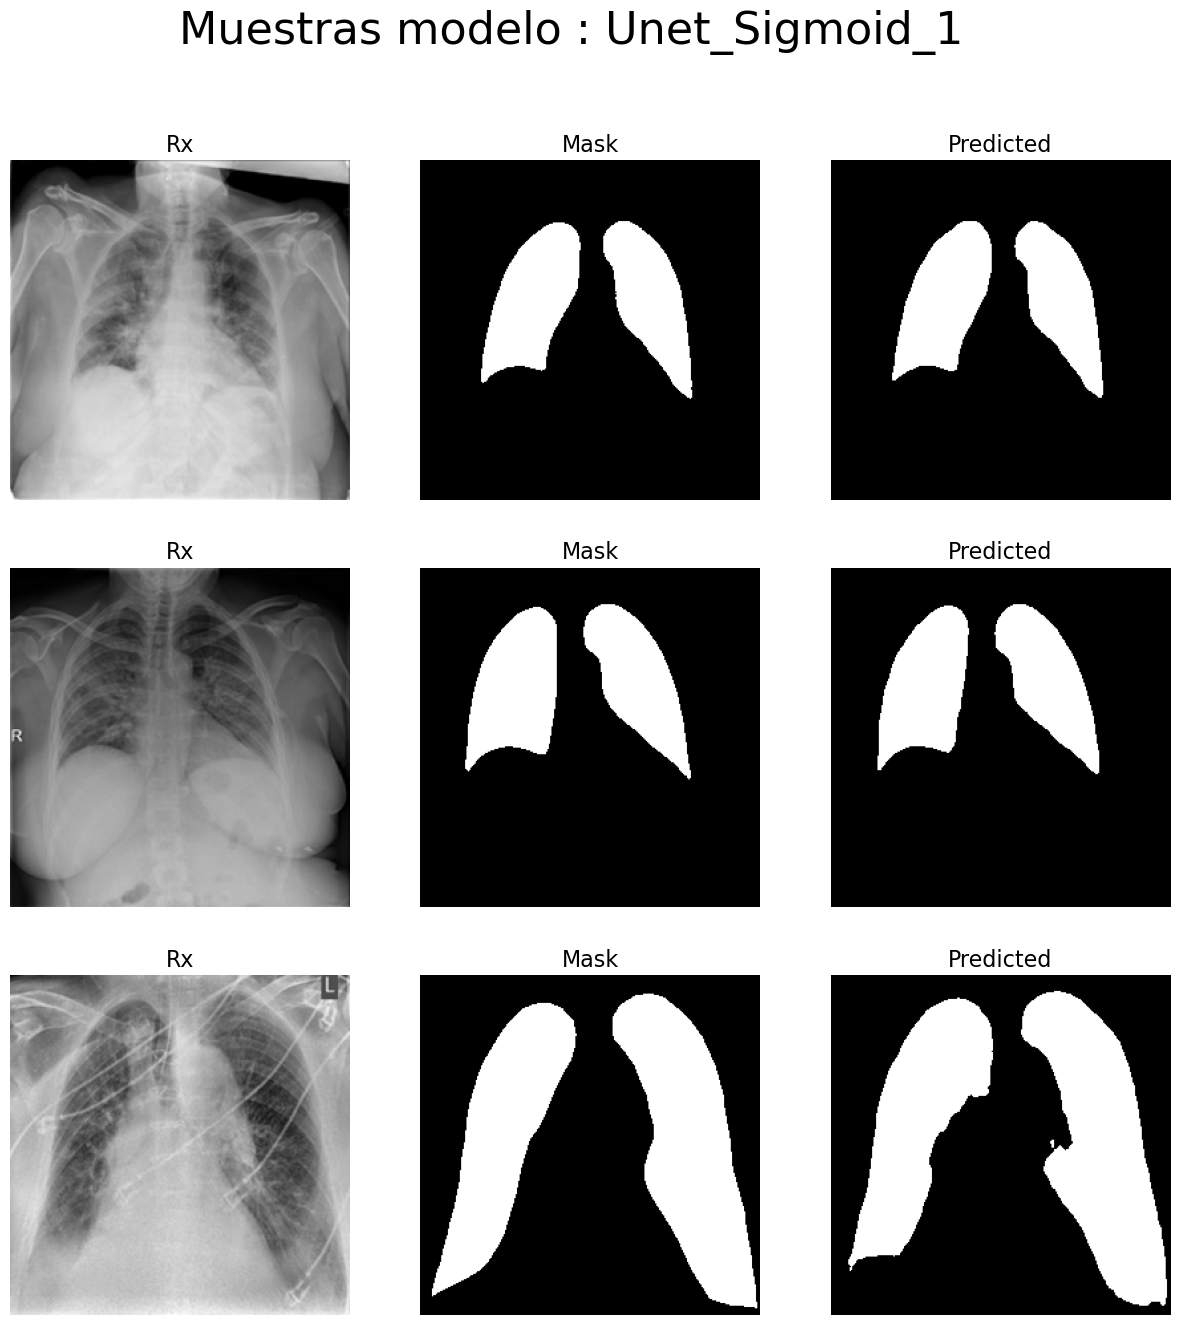

In [ ]:
model_name =  'Unet_Sigmoid_1'      # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 6                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'sigmoid'              # Función de activación
adam_value = 0.00005                # Valor Adam
epochs = 6                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
inicio = time.time()
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)
fin = time.time()

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])


path_save = os.path.join(path_save_modelos,model_name)
os.makedirs(path_save,exist_ok=True)    # Creación de carpeta por modelo

path_save_model= os.path.join(path_save,model_name + '.keras') 
model.save(path_save_model) # Guardado del modelo
model_name_all.append(model_name)

# Escritura de información del modelo
my_file = open(os.path.join(path_save,f"Info{model_name}.txt"),"w")
my_file.write(f" Nombre del modelo : {model_name}\n")
my_file.write(f" Tamaño de la imagen : {image_size}\n")
my_file.write(f" Tamaño del lote : {batch_size}\n")
my_file.write(f" Capas : {f}\n")
my_file.write(f" Función de activación : {activation}\n")
my_file.write(f" Valor Adam : {adam_value:,.6f}\n")
my_file.write(f" Tiempo de entrenamiento : {fin-inicio:,.2f} segundos\n")
my_file.write(f" Valor de precisión en el conjunto de validación : {history.history['val_acc'][-1]} \n")
my_file.write(f" Valor de perdida en el conjunto de validación : {history.history['val_loss'][-1]} \n")
my_file.close()

# Imagen con ejemplos de predicciones
plt.figure(figsize= [15,15])
plt.suptitle(f"Muestras modelo : {model_name}", fontsize = 32)
for i in range(3):
    x,y = train_gen.__getitem__(i)
    y_predicted = model.predict(x,verbose = 0)

    plt.subplot( 3 , 3 , i * 3 + 1)
    plt.axis("off")
    plt.title("Rx", fontsize = 16)
    plt.imshow(x[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 2)
    plt.axis("off")
    plt.title("Mask", fontsize = 16)
    plt.imshow(y[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 3)
    plt.axis("off")
    plt.title("Predicted", fontsize = 16)
    plt.imshow(y_predicted[0,:,:,0] > 0.5, cmap="gray")

path_save_img = os.path.join(path_save, model_name + '.png') # Guardado del modelo
plt.savefig(path_save_img, bbox_inches='tight')

Epoch 1/6
2714/2714 [==============================] - 990s 357ms/step - loss: 0.1538 - acc: 0.9382 - val_loss: 0.0698 - val_acc: 0.9732
Epoch 2/6
2714/2714 [==============================] - 442s 163ms/step - loss: 0.0684 - acc: 0.9736 - val_loss: 0.0791 - val_acc: 0.9696
Epoch 3/6
2714/2714 [==============================] - 443s 163ms/step - loss: 0.0538 - acc: 0.9790 - val_loss: 0.0596 - val_acc: 0.9769
Epoch 4/6
2714/2714 [==============================] - 413s 152ms/step - loss: 0.0472 - acc: 0.9814 - val_loss: 0.0549 - val_acc: 0.9784
Epoch 5/6
2714/2714 [==============================] - 193s 71ms/step - loss: 0.0446 - acc: 0.9823 - val_loss: 0.0588 - val_acc: 0.9775
Epoch 6/6
2714/2714 [==============================] - 191s 70ms/step - loss: 0.0432 - acc: 0.9829 - val_loss: 0.0504 - val_acc: 0.9802


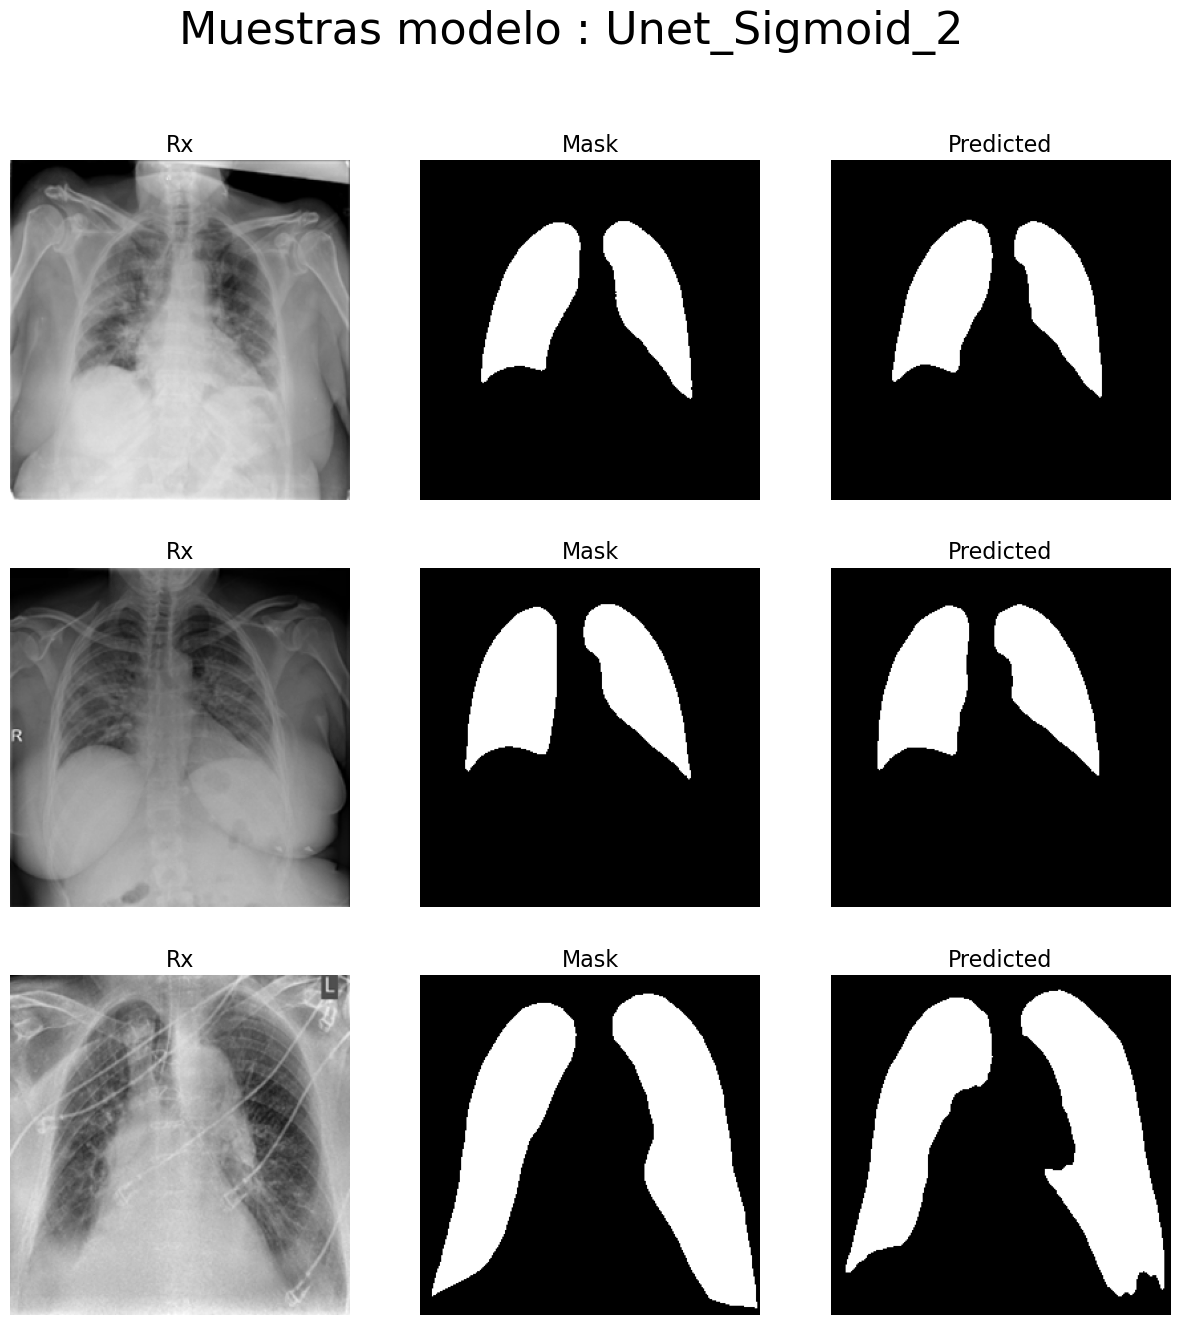

In [6]:
model_name =  'Unet_Sigmoid_2'   # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 8                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'sigmoid'              # Función de activación
adam_value = 0.00001                # Valor Adam
epochs = 6                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
inicio = time.time()
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)
fin = time.time()

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])


path_save = os.path.join(path_save_modelos,model_name)
os.makedirs(path_save,exist_ok=True)    # Creación de carpeta por modelo

path_save_model= os.path.join(path_save,model_name + '.keras') 
model.save(path_save_model) # Guardado del modelo
model_name_all.append(model_name)

# Escritura de información del modelo
my_file = open(os.path.join(path_save,f"Info{model_name}.txt"),"w")
my_file.write(f" Nombre del modelo : {model_name}\n")
my_file.write(f" Tamaño de la imagen : {image_size}\n")
my_file.write(f" Tamaño del lote : {batch_size}\n")
my_file.write(f" Capas : {f}\n")
my_file.write(f" Función de activación : {activation}\n")
my_file.write(f" Valor Adam : {adam_value:,.6f}\n")
my_file.write(f" Tiempo de entrenamiento : {fin-inicio:,.2f} segundos\n")
my_file.write(f" Valor de precisión en el conjunto de validación : {history.history['val_acc'][-1]} \n")
my_file.write(f" Valor de perdida en el conjunto de validación : {history.history['val_loss'][-1]} \n")
my_file.close()

# Imagen con ejemplos de predicciones
plt.figure(figsize= [15,15])
plt.suptitle(f"Muestras modelo : {model_name}", fontsize = 32)
for i in range(3):
    x,y = train_gen.__getitem__(i)
    y_predicted = model.predict(x,verbose = 0)

    plt.subplot( 3 , 3 , i * 3 + 1)
    plt.axis("off")
    plt.title("Rx", fontsize = 16)
    plt.imshow(x[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 2)
    plt.axis("off")
    plt.title("Mask", fontsize = 16)
    plt.imshow(y[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 3)
    plt.axis("off")
    plt.title("Predicted", fontsize = 16)
    plt.imshow(y_predicted[0,:,:,0] > 0.5, cmap="gray")

path_save_img = os.path.join(path_save, model_name + '.png') # Guardado del modelo
plt.savefig(path_save_img, bbox_inches='tight')

Epoch 1/6
2714/2714 [==============================] - 764s 281ms/step - loss: 0.1278 - acc: 0.9491 - val_loss: 0.0562 - val_acc: 0.9774
Epoch 2/6
2714/2714 [==============================] - 437s 161ms/step - loss: 0.0536 - acc: 0.9793 - val_loss: 0.0594 - val_acc: 0.9774
Epoch 3/6
2714/2714 [==============================] - 437s 161ms/step - loss: 0.0452 - acc: 0.9823 - val_loss: 0.0682 - val_acc: 0.9749
Epoch 4/6
2714/2714 [==============================] - 436s 161ms/step - loss: 0.0398 - acc: 0.9843 - val_loss: 0.0430 - val_acc: 0.9825
Epoch 5/6
2714/2714 [==============================] - 436s 161ms/step - loss: 0.0353 - acc: 0.9859 - val_loss: 0.0489 - val_acc: 0.9821
Epoch 6/6
2714/2714 [==============================] - 243s 90ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 0.0780 - val_acc: 0.9719


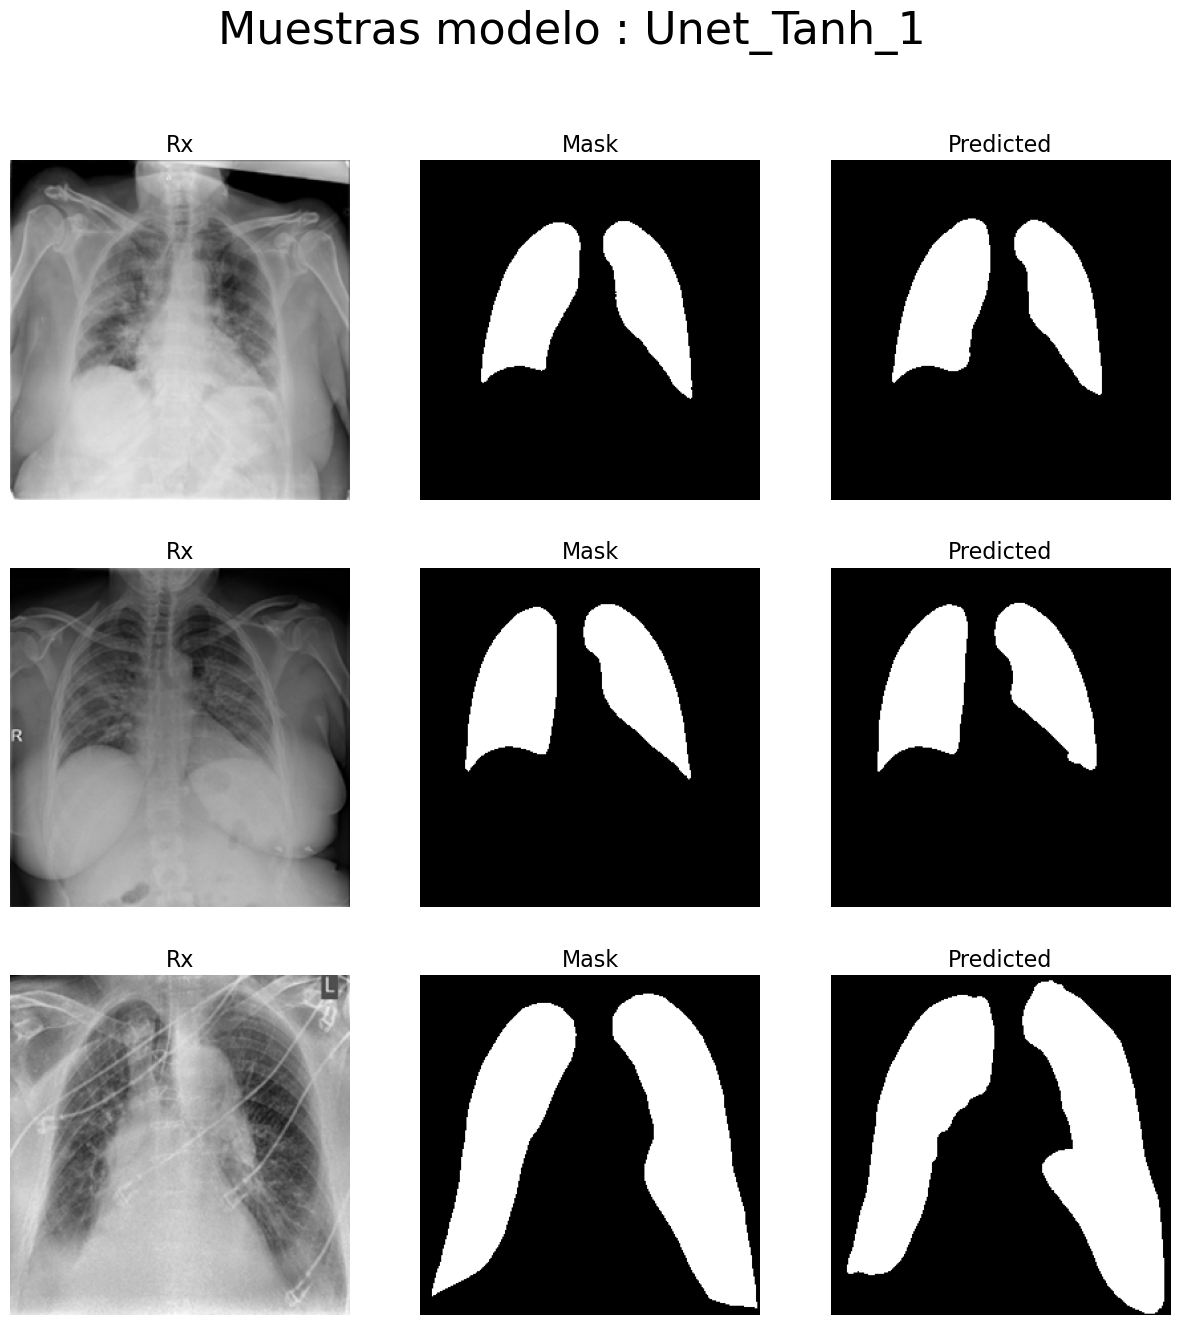

In [7]:
model_name =  'Unet_Tanh_1'   # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 8                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'tanh'              # Función de activación
adam_value = 0.00005                # Valor Adam
epochs = 6                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
inicio = time.time()
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)
fin = time.time()

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])


path_save = os.path.join(path_save_modelos,model_name)
os.makedirs(path_save,exist_ok=True)    # Creación de carpeta por modelo

path_save_model= os.path.join(path_save,model_name + '.keras') 
model.save(path_save_model) # Guardado del modelo
model_name_all.append(model_name)

# Escritura de información del modelo
my_file = open(os.path.join(path_save,f"Info{model_name}.txt"),"w")
my_file.write(f" Nombre del modelo : {model_name}\n")
my_file.write(f" Tamaño de la imagen : {image_size}\n")
my_file.write(f" Tamaño del lote : {batch_size}\n")
my_file.write(f" Capas : {f}\n")
my_file.write(f" Función de activación : {activation}\n")
my_file.write(f" Valor Adam : {adam_value:,.6f}\n")
my_file.write(f" Tiempo de entrenamiento : {fin-inicio:,.2f} segundos\n")
my_file.write(f" Valor de precisión en el conjunto de validación : {history.history['val_acc'][-1]} \n")
my_file.write(f" Valor de perdida en el conjunto de validación : {history.history['val_loss'][-1]} \n")
my_file.close()

# Imagen con ejemplos de predicciones
plt.figure(figsize= [15,15])
plt.suptitle(f"Muestras modelo : {model_name}", fontsize = 32)
for i in range(3):
    x,y = train_gen.__getitem__(i)
    y_predicted = model.predict(x,verbose = 0)

    plt.subplot( 3 , 3 , i * 3 + 1)
    plt.axis("off")
    plt.title("Rx", fontsize = 16)
    plt.imshow(x[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 2)
    plt.axis("off")
    plt.title("Mask", fontsize = 16)
    plt.imshow(y[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 3)
    plt.axis("off")
    plt.title("Predicted", fontsize = 16)
    plt.imshow(y_predicted[0,:,:,0] > 0.5, cmap="gray")

path_save_img = os.path.join(path_save, model_name + '.png') # Guardado del modelo
plt.savefig(path_save_img, bbox_inches='tight')

Epoch 1/6
2714/2714 [==============================] - 568s 209ms/step - loss: 0.2546 - acc: 0.9083 - val_loss: 0.0880 - val_acc: 0.9644
Epoch 2/6
2714/2714 [==============================] - 204s 75ms/step - loss: 0.1073 - acc: 0.9591 - val_loss: 0.0849 - val_acc: 0.9675
Epoch 3/6
2714/2714 [==============================] - 194s 71ms/step - loss: 0.0688 - acc: 0.9737 - val_loss: 0.0757 - val_acc: 0.9701
Epoch 4/6
2714/2714 [==============================] - 194s 71ms/step - loss: 0.0614 - acc: 0.9766 - val_loss: 0.0674 - val_acc: 0.9745
Epoch 5/6
2714/2714 [==============================] - 201s 74ms/step - loss: 0.0557 - acc: 0.9789 - val_loss: 0.0937 - val_acc: 0.9679
Epoch 6/6
2714/2714 [==============================] - 203s 75ms/step - loss: 0.0539 - acc: 0.9796 - val_loss: 0.0559 - val_acc: 0.9779


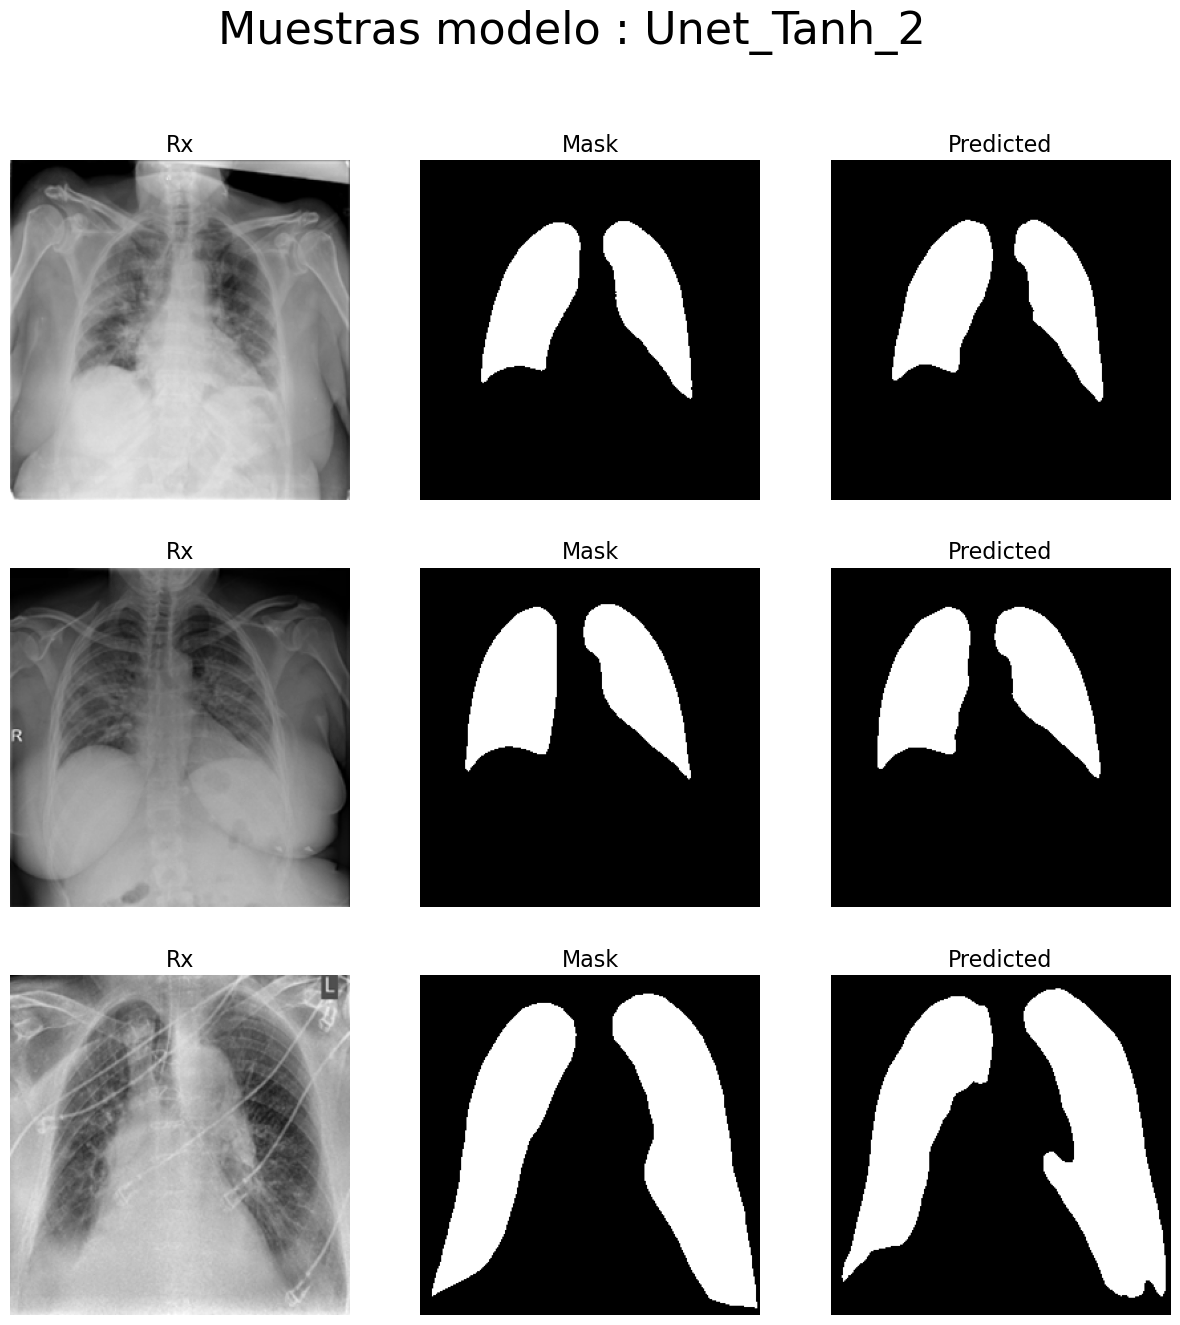

In [8]:
model_name =  'Unet_Tanh_2'   # Nombre del modelo
image_size = 256                    # Tamano de las imágenes
batch_size = 8                      # Tamano del batch
f = [64, 128, 256, 512, 1024]       # Numéro de capas convolucionales
activation = 'tanh'              # Función de activación
adam_value = 0.00001                # Valor Adam
epochs = 6                         # Número de épocas
Adam = keras.optimizers.Adam(learning_rate=adam_value)

# Generación de datos a partir de función
train_gen = SegGen(train_ids, train_path_rx, train_path_mask, batch_size=batch_size, image_size=image_size)
valid_gen = SegGen(validation_ids, validation_path_rx, validation_path_mask, batch_size=batch_size, image_size=image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(validation_ids)//batch_size

model = UNet( image_size, f , activation)  # Creación del modelo U-Net
model.compile(optimizer=Adam, loss="binary_crossentropy", metrics=["acc"])  # Ajuste de hiperparametros
# Entrenamiento del modelo
inicio = time.time()
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, verbose=1)
fin = time.time()

Acuracy.append(history.history['val_acc'])
Loss.append(history.history['val_loss'])


path_save = os.path.join(path_save_modelos,model_name)
os.makedirs(path_save,exist_ok=True)    # Creación de carpeta por modelo

path_save_model= os.path.join(path_save,model_name + '.keras') 
model.save(path_save_model) # Guardado del modelo
model_name_all.append(model_name)

# Escritura de información del modelo
my_file = open(os.path.join(path_save,f"Info{model_name}.txt"),"w")
my_file.write(f" Nombre del modelo : {model_name}\n")
my_file.write(f" Tamaño de la imagen : {image_size}\n")
my_file.write(f" Tamaño del lote : {batch_size}\n")
my_file.write(f" Capas : {f}\n")
my_file.write(f" Función de activación : {activation}\n")
my_file.write(f" Valor Adam : {adam_value:,.6f}\n")
my_file.write(f" Tiempo de entrenamiento : {fin-inicio:,.2f} segundos\n")
my_file.write(f" Valor de precisión en el conjunto de validación : {history.history['val_acc'][-1]} \n")
my_file.write(f" Valor de perdida en el conjunto de validación : {history.history['val_loss'][-1]} \n")
my_file.close()

# Imagen con ejemplos de predicciones
plt.figure(figsize= [15,15])
plt.suptitle(f"Muestras modelo : {model_name}", fontsize = 32)
for i in range(3):
    x,y = train_gen.__getitem__(i)
    y_predicted = model.predict(x,verbose = 0)

    plt.subplot( 3 , 3 , i * 3 + 1)
    plt.axis("off")
    plt.title("Rx", fontsize = 16)
    plt.imshow(x[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 2)
    plt.axis("off")
    plt.title("Mask", fontsize = 16)
    plt.imshow(y[0,:,:,0], cmap="gray")

    plt.subplot( 3 , 3 , i * 3 + 3)
    plt.axis("off")
    plt.title("Predicted", fontsize = 16)
    plt.imshow(y_predicted[0,:,:,0] > 0.5, cmap="gray")

path_save_img = os.path.join(path_save, model_name + '.png') # Guardado del modelo
plt.savefig(path_save_img, bbox_inches='tight')

Modelo sigmoid_1 Precisión : 0.9858912825584412
Modelo sigmoid_2 Precisión : 0.9802293181419373
Modelo tanh_1 Precisión : 0.9719243049621582
Modelo tanh_2 Precisión : 0.9779388308525085


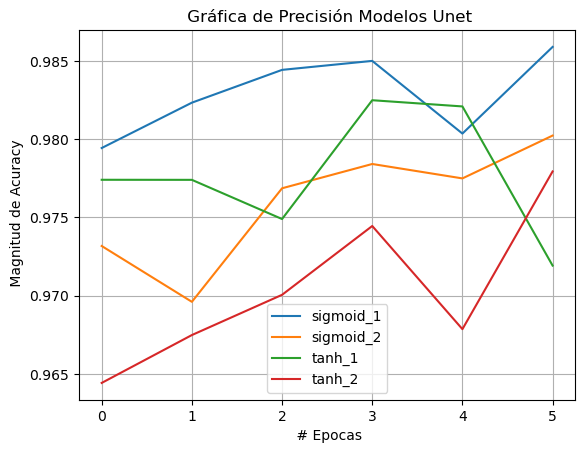

In [9]:
modelos = ['sigmoid_1','sigmoid_2',"tanh_1","tanh_2"]
plt.figure()
plt.title(f' Gráfica de Precisión Modelos Unet')
plt.xlabel(' # Epocas')
plt.ylabel(' Magnitud de Acuracy')
plt.grid()
ac_max = 0

for i,ac in enumerate(Acuracy):
    plt.plot(ac)
    print(f'Modelo {modelos[i]} Precisión : {ac[-1]}')

    if ac[-1] > ac_max:
        ac_max = ac[-1]
        model_final = model_name_all[i]

plt.legend(modelos)

path_save = os.path.join(path_save_modelos,"AcuracyModelos.png")
plt.savefig(path_save)

Modelo sigmoid_1 Precisión : 0.035819072276353836
Modelo sigmoid_2 Precisión : 0.05044999718666077
Modelo tanh_1 Precisión : 0.07800494134426117
Modelo tanh_2 Precisión : 0.05589189752936363


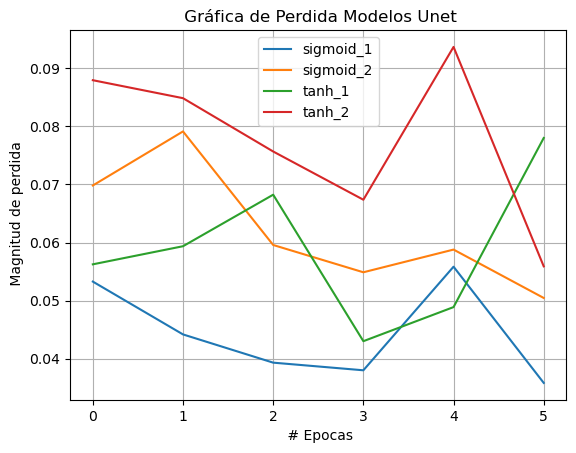

In [10]:
plt.figure()
plt.title(f' Gráfica de Perdida Modelos Unet')
plt.xlabel(' # Epocas')
plt.ylabel(' Magnitud de perdida')
plt.grid()

for i,ac in enumerate(Loss):
    plt.plot(ac)
    print(f'Modelo {modelos[i]} Perdida : {ac[-1]}')
plt.legend(modelos)

path_save = os.path.join(path_save_modelos,"LossModelos.png")
plt.savefig(path_save)

In [11]:
# Mover modelo final de carpeta
path_origen = os.path.join(path_save_modelos,model_final,model_final + ".keras")
path_destino = os.path.join(os.path.split(path_save_modelos)[0], "ModelSegmenta.keras")
shutil.copy(path_origen,path_destino)

'Models/Sementacion\\ModelSegmenta.keras'